# WebRender dashboard ETL script

You probably want to look at the [published dashboard](file:///Users/tsmith/projects/webrender-dashboard/dashboard.html).

You can check [scheduled run status](https://dbc-caf9527b-e073.cloud.databricks.com/#job/715).


### What's different?

* Metrics are summarized by build (vs date).
* Performance metrics are aggregated over users; this is important because it reduces the impacts of outlier users on our understanding of product performance, and because it reflects how WebRender changes the user experience at the user level.
* Pings are artisanally hand-selected so that comparisons between experiment branches are fair even in the presence of the various enrollment weirdnesses.

In [2]:
%r
library(boot)
library(dplyr, warn.conflicts=FALSE)
library(ggplot2)
library(sparklyr, warn.conflicts=FALSE)
library(tidyr, warn.conflicts=FALSE)

sc = spark_connect(method="databricks")

# Save result tables so we can access them from hala
final_outdb_path = "/dbfs/tdsmith/webrender.sqlite3"

In [3]:
from moztelemetry.dataset import Dataset
import pandas as pd
from pyspark.sql import Row
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, BooleanType, IntegerType, DoubleType, LongType, MapType
from statsmodels.stats.weightstats import DescrStatsW

EXPERIMENT_ID = "prefflip-webrender-v1-2-1492568"
EXPERIMENT_ID_2 = "prefflip-webrender-v1-3-1492568"
PARTITIONS = [s.replace("-", "_") for s in (EXPERIMENT_ID, EXPERIMENT_ID_2)]

In [4]:
to_summarize = {
  "composite_time": "payload.processes.gpu.histograms.COMPOSITE_TIME",
  "content_frame_time": "payload.processes.gpu.histograms.CONTENT_FRAME_TIME",
  "content_frame_time_vsync": "payload.processes.gpu.histograms.CONTENT_FRAME_TIME_VSYNC",
  "content_paint_time": "payload.processes.content.histograms.CONTENT_PAINT_TIME",
  "tab_switch_composite": "payload.histograms.FX_TAB_SWITCH_COMPOSITE_E10S_MS",
  "content_full_paint_time": "payload.processes.gpu.histograms.CONTENT_FULL_PAINT_TIME",
  "page_load_ms": "payload.histograms.FX_PAGE_LOAD_MS_2"
}

to_pull = {}
for k, v in to_summarize.items():
  to_pull[k] = v + ".values"
  to_pull[k + "_sum"] = v + ".sum"

pings = (
  Dataset
  .from_source("telemetry-cohorts")
  .where(
    docType="main",
    experimentId=lambda x: x in PARTITIONS,
    submissionDate=lambda x: int(x) >= 20190102,
#    appBuildId='20190104093221',
  )
  .select(
    app_build_id="application.buildId",
    branch='environment.experiments."%s".branch' % EXPERIMENT_ID,
    branch2='environment.experiments."%s".branch' % EXPERIMENT_ID_2,
    client_id="clientId",
    gfx_compositor="environment.system.gfx.features.compositor",
    normalized_channel="meta.normalizedChannel",
    profile_subsession_counter="payload.info.profileSubsessionCounter",
    session_id="payload.info.sessionId",
    target_pref_value='environment.settings.userPrefs."gfx.webrender.all.qualified"',
    # ---
    device_reset_reason_content="payload.processes.content.histograms.DEVICE_RESET_REASON.values",
    device_reset_reason_gpu="payload.processes.gpu.histograms.DEVICE_RESET_REASON.values",
    device_reset_reason_parent="payload.histograms.DEVICE_RESET_REASON.values",
    subsession_length="payload.info.subsessionLength",
    active_ticks='payload.processes.parent.scalars."browser.engagement.active_ticks"',
    total_uris='payload.processes.parent.scalars."browser.engagement.total_uri_count"',
    **to_pull
  )
  .records(sc)
)

def ping_to_row(x):
  for k, v in to_summarize.items():
    x[k + "_count"] = sum((x[k] or {}).values())
  
  x["experiment"] = (x["branch"] and 2) or 3
  x["branch"] = x["branch"] or x["branch2"]
  del x["branch2"]
  
  # Aggregate DEVICE_RESET_REASON for crash rates
  procs = ("parent", "content", "gpu")
  x["device_reset_reason_total"] = 0
  for proc in procs:
    key = "device_reset_reason_" + proc
    x[key + "_count"] = sum((x[key] or {}).values())
    x["device_reset_reason_total"] += x[key + "_count"]
    del x[key]
  
  # Calculate usage hours for crash rates
  # Based on https://github.com/mozilla/telemetry-streaming/blob/ee2eafd18a8b12a3fafca496d58789f641069bf6/src/main/scala/com/mozilla/telemetry/pings/MainPing.scala#L71-L82
  subsession_length = x["subsession_length"] or 0
  x["usage_hours"] = max(min(subsession_length/3600., 25.), 0.)
  return Row(**x)

fetching 9364.65380MB in 3013 files...

In [5]:
sdf_fields = [
  StructField("app_build_id", StringType(), True),
  StructField("branch", StringType(), False),
  StructField("client_id", StringType(), False),
  StructField("experiment", IntegerType(), False),
  StructField("gfx_compositor", StringType(), True),
  StructField("normalized_channel", StringType(), True),
  StructField("profile_subsession_counter", LongType(), True),  
  StructField("session_id", StringType(), True),
  StructField("target_pref_value", BooleanType(), True),
  StructField("device_reset_reason_parent_count", LongType(), True),
  StructField("device_reset_reason_content_count", LongType(), True),
  StructField("device_reset_reason_gpu_count", LongType(), True),
  StructField("device_reset_reason_total", LongType(), True),
  StructField("active_ticks", LongType(), True),
  StructField("total_uris", LongType(), True),
  StructField("subsession_length", LongType(), True),
  StructField("usage_hours", DoubleType(), True),
]

for k, v in to_summarize.items():
  sdf_fields.extend([
    StructField(k, MapType(StringType(), LongType()), True),
    StructField(k + "_sum", LongType(), True),
    StructField(k + "_count", LongType(), True),
  ])

sdf = spark.createDataFrame(pings.map(ping_to_row), schema=StructType(sdf_fields))

In [6]:
sdf.cache()
None

In [7]:
# Because compositor changes don't take effect until the browser restarts,
# we should discard the enrollment session we observe for each client.
# We'll find those sessions here, and then anti-join against this table later.

first_sessions = (
  sdf
  .orderBy(sdf.experiment, sdf.client_id, sdf.branch, sdf.profile_subsession_counter)
  .groupBy(sdf.experiment, sdf.client_id, sdf.branch)
  .agg(
    f.first(sdf.session_id).alias("session_id"),
  )
)

In [8]:
# Broadcast joins time-out unless the cluster is warm
spark.sql("SET spark.sql.autoBroadcastJoinThreshold = -1")

subsessions = (
  sdf
  .join(first_sessions, on=["experiment", "client_id", "branch", "session_id"], how="left_anti")
  .where(sdf.target_pref_value.isNotNull())
  .where(
    ((sdf.branch == "disabled") & (sdf.gfx_compositor == "d3d11"))
    | ((sdf.branch == "enabled") & (sdf.gfx_compositor == "webrender"))
  )
  .where(
    (sdf.normalized_channel == "beta") | (sdf.normalized_channel == "nightly")
  )
  .filter("app_build_id >= '20190104093221'")
  .cache()
)

In [9]:
subsessions.createOrReplaceGlobalTempView("webrender_metrics")

In [10]:
# Compute per-user quantiles for CONTENT_PAINT_TIME

def generate_quantile_udf(sdf, grouping_fields, bucket_field, count_field, quantiles):
  """
  sdf: Spark DataFrame
  grouping_fields: list of strings representing columns from sdf
  bucket_field: Name of the field containing histogram buckets
  count_field: Name of the field containing counts
  quantiles: List of quantiles as floating point values on [0, 1]
  """
  schema = (
    sdf
    .select(*grouping_fields)
    .schema
    .add(StructField("quantile", DoubleType(), False))
    .add(StructField("value", DoubleType(), True))
  )
  
  @f.pandas_udf(schema, f.PandasUDFType.GROUPED_MAP)
  def udf(df):
    stats = DescrStatsW(df[bucket_field].astype(float), df[count_field]).quantile(quantiles)
    stats = stats.rename_axis("quantile").reset_index(name="value").assign(_dummy=1)
    grouping_variables = df[grouping_fields].iloc[:1].assign(_dummy=1)
    result = grouping_variables.merge(stats, on="_dummy").drop("_dummy", axis=1)
    return result
  
  return udf

metric_quantiles = generate_quantile_udf(
  subsessions,
  ["client_id", "branch", "app_build_id", "normalized_channel"],
  bucket_field="bucket",
  count_field="count",
  quantiles=[0.5, 0.9, 0.95, 0.99]
)

paint_time_quantiles = (
  subsessions
  .select(
    subsessions.client_id,
    subsessions.branch,
    subsessions.normalized_channel,
    subsessions.app_build_id,
    f.explode(subsessions.content_paint_time).alias("bucket", "count")
  )
  .groupBy(subsessions.client_id, subsessions.branch, subsessions.app_build_id, subsessions.normalized_channel, "bucket")
  .agg(f.sum("count").alias("count"))
  .groupBy(subsessions.client_id, subsessions.branch, subsessions.app_build_id, subsessions.normalized_channel)
  .apply(metric_quantiles)
)

paint_time_quantiles.createOrReplaceGlobalTempView("wr_paint_time_quantiles")

In [11]:
ping = (subsessions
  .select(
    subsessions.client_id,
    subsessions.branch,
    subsessions.normalized_channel,
    subsessions.app_build_id,
    subsessions.content_frame_time,
  ).take(1))

In [12]:
count_field = "count"
bucket_field = "bucket"
tx = 200
rows = [(int(key), value) for (key, value) in ping[0]['content_frame_time'].items()]
df = pd.DataFrame(rows, columns=["bucket", "count"])
df.sort_values(by="bucket", inplace=True)
df = df.reset_index(drop=True)
all_sum = float(df[count_field].sum())
fraction = df.loc[df[bucket_field].astype(int) >= tx, count_field].sum() / all_sum
weighted_fraction = (df['count'] * df['bucket']/100) .sum() / all_sum
import numpy as np
disc_weighted_fraction = (np.maximum(df['bucket'].astype(int).floordiv(100)-1, 0)*df['count']).sum() / all_sum
all_sum, fraction, weighted_fraction, disc_weighted_fraction


Out[ 77 ]: (48314.0, 0.03359274744380511, 1.1548764333319534, 0.05482882808295732)

In [13]:
# Changes to CONTENT_FRAME_TIME are only user-visible when CONTENT_FRAME_TIME exceeds 200.
# Count the fraction of CONTENT_FRAME_TIME events where the threshold is exceeded.
# (The threshold is set to 192 because of the binning of the histogram.)

def generate_weighted_threshold_udf(sdf, grouping_fields, bucket_field, count_field):
  """
  sdf: Spark DataFrame
  grouping_fields: list of strings representing columns from sdf
  bucket_field: Name of the field containing histogram buckets
  count_field: Name of the field containing counts
  thresholds: List of thresholds. Should probably align on the left edge of a bucket.
  """
  schema = (
    sdf
    .select(*grouping_fields)
    .schema
    .add(StructField("threshold", IntegerType(), False))
    .add(StructField("fraction_exceeding", DoubleType(), True))
  )
  
  @f.pandas_udf(schema, f.PandasUDFType.GROUPED_MAP)
  def udf(df):
    rows = []
    all_sum = float(df[count_field].sum())

    fraction = (np.maximum(df['bucket'].astype(int).floordiv(100)-1, 0)*df['count']).sum() / all_sum
    rows.append({"threshold": 200, "fraction_exceeding": fraction})
    data = pd.DataFrame(rows).assign(_dummy=1)
    grouping_variables = df[grouping_fields].iloc[:1].assign(_dummy=1)
    result = grouping_variables.merge(data, on="_dummy").drop("_dummy", axis=1)
    return result
  
  return udf

vsync_threshold = generate_weighted_threshold_udf(
  subsessions,
  ["client_id", "branch", "app_build_id", "normalized_channel"],
  bucket_field="bucket",
  count_field="count",
)

weighted_content_frame_time_vsync = (
  subsessions
  .select(
    subsessions.client_id,
    subsessions.branch,
    subsessions.normalized_channel,
    subsessions.app_build_id,
    f.explode(subsessions.content_frame_time_vsync).alias("bucket", "count")
  )
  .groupBy(subsessions.client_id, subsessions.branch, subsessions.app_build_id, subsessions.normalized_channel)
  .apply(vsync_threshold)
)

weighted_content_frame_time_vsync.createOrReplaceGlobalTempView("wr_weighted_content_frame_time_vsync")

In [14]:
# Changes to CONTENT_FRAME_TIME are only user-visible when CONTENT_FRAME_TIME exceeds 200.
# Count the fraction of CONTENT_FRAME_TIME events where the threshold is exceeded.
# (The threshold is set to 192 because of the binning of the histogram.)

def generate_threshold_udf(sdf, grouping_fields, bucket_field, count_field, thresholds):
  """
  sdf: Spark DataFrame
  grouping_fields: list of strings representing columns from sdf
  bucket_field: Name of the field containing histogram buckets
  count_field: Name of the field containing counts
  thresholds: List of thresholds. Should probably align on the left edge of a bucket.
  """
  schema = (
    sdf
    .select(*grouping_fields)
    .schema
    .add(StructField("threshold", IntegerType(), False))
    .add(StructField("fraction_exceeding", DoubleType(), True))
  )
  
  @f.pandas_udf(schema, f.PandasUDFType.GROUPED_MAP)
  def udf(df):
    rows = []
    all_sum = float(df[count_field].sum())
    for tx in thresholds:
      fraction = df.loc[df[bucket_field].astype(int) >= tx, count_field].sum() / all_sum
      rows.append({"threshold": tx, "fraction_exceeding": fraction})
    data = pd.DataFrame(rows).assign(_dummy=1)
    grouping_variables = df[grouping_fields].iloc[:1].assign(_dummy=1)
    result = grouping_variables.merge(data, on="_dummy").drop("_dummy", axis=1)
    return result
  
  return udf

vsync_threshold = generate_threshold_udf(
  subsessions,
  ["client_id", "branch", "app_build_id", "normalized_channel"],
  bucket_field="bucket",
  count_field="count",
  thresholds=[192],
)

slow_content_frame_time = (
  subsessions
  .select(
    subsessions.client_id,
    subsessions.branch,
    subsessions.normalized_channel,
    subsessions.app_build_id,
    f.explode(subsessions.content_frame_time).alias("bucket", "count")
  )
  .groupBy(subsessions.client_id, subsessions.branch, subsessions.app_build_id, subsessions.normalized_channel)
  .apply(vsync_threshold)
)

slow_content_frame_time.createOrReplaceGlobalTempView("wr_slow_content_frame_time")

In [15]:
# Changes to CONTENT_FRAME_TIME_VSYNC are only user-visible when CONTENT_FRAME_TIME_VSYNC exceeds 200.
# Count the fraction of CONTENT_FRAME_TIME_VSYNC events where the threshold is exceeded.

vsync_threshold = generate_threshold_udf(
  subsessions,
  ["client_id", "branch", "app_build_id", "normalized_channel"],
  bucket_field="bucket",
  count_field="count",
  thresholds=[200, 300, 400, 500, 600, 700],
)

slow_content_frame_time_vsync = (
  subsessions
  .select(
    subsessions.client_id,
    subsessions.branch,
    subsessions.normalized_channel,
    subsessions.app_build_id,
    f.explode(subsessions.content_frame_time_vsync).alias("bucket", "count")
  )
  .groupBy(subsessions.client_id, subsessions.branch, subsessions.app_build_id, subsessions.normalized_channel)
  .apply(vsync_threshold)
)

slow_content_frame_time_vsync.createOrReplaceGlobalTempView("wr_slow_content_frame_time_vsync")
slow_content_frame_time_vsync.count()

Out[ 104 ]: 8478

In [16]:
slow_content_frame_time_vsync.select('app_build_id').rdd.countByValue()

Out[ 105 ]: defaultdict(<type 'int'>, {Row(app_build_id=u'20190104214806'): 3468, Row(app_build_id=u'20190105215256'): 42, Row(app_build_id=u'20190104132412'): 2922, Row(app_build_id=u'20190105123739'): 1722, Row(app_build_id=u'20190104093221'): 324})

In [17]:
# Summarize instances of other performance metrics exceeding 16ms

# to_summarize = {
#   "composite_time": "payload.processes.gpu.histograms.COMPOSITE_TIME",
#   "content_paint_time": "payload.processes.content.histograms.CONTENT_PAINT_TIME",
#   "content_full_paint_time": "payload.processes.gpu.histograms.CONTENT_FULL_PAINT_TIME",
# }

time_threshold = generate_threshold_udf(
  subsessions,
  ["client_id", "branch", "app_build_id", "normalized_channel"],
  bucket_field="bucket",
  count_field="count",
  thresholds=[16],
)

time_threshold_histograms = ["composite_time", "content_paint_time", "content_full_paint_time"]
for h in time_threshold_histograms:
  slow_df = (
    subsessions
    .select(
      subsessions.client_id,
      subsessions.branch,
      subsessions.normalized_channel,
      subsessions.app_build_id,
      f.explode(h).alias("bucket", "count")
    )
    .groupBy(subsessions.client_id, subsessions.branch, subsessions.app_build_id, subsessions.normalized_channel)
    .apply(time_threshold)
  )
  slow_df.createOrReplaceGlobalTempView("wr_slow_%s" % h)

## Performance metrics

Error bars are 95% confidence intervals for the central parameter of the per-user aggregate assuming a log-normal population distribution.

In [19]:
%r
metrics = tbl(sc, "global_temp.webrender_metrics")
per_user_build = metrics %>%
  select(app_build_id, normalized_channel, branch, client_id, ends_with("_count"), ends_with("_sum")) %>%
  select(-starts_with("device_reset_reason")) %>%
  group_by(app_build_id, normalized_channel, branch, client_id) %>%
  summarize_all(sum) %>%
  collect %>%
  gather("metric", "value", ends_with("_count"), ends_with("_sum")) %>%
  separate(metric, c("metric", "agg"), sep="_(?!.*_)") %>%
  spread(agg, value) %>%
  mutate(mean=sum/count)

In [20]:
%r
perf_medians = per_user_build %>%
  group_by(app_build_id, normalized_channel, branch, metric) %>%
  summarize(
    user_median=median(mean, na.rm=TRUE),
    log_sd=sd(log10(mean+1), na.rm=TRUE),
    log_sem=log_sd/sqrt(n()),
    log_ymin=log10(user_median)-1.96*log_sem,
    log_ymax=log10(user_median)+1.96*log_sem
  )

In [21]:
%r
slow_content_frame_time = tbl(sc, "global_temp.wr_slow_content_frame_time") %>% collect

In [22]:
%r
slow_content_frame_boot = function(df) {
  ci = boot(df$fraction_exceeding, function(data, x) median(data[x], na.rm=TRUE), 1000) %>%
     boot.ci(0.95, "basic")
  data.frame(
    ymin=ci$basic[4],
    y=ci$t0,
    ymax=ci$basic[5]
  ) * 100
}

slow_content_frame_time_summary = slow_content_frame_time %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  do(slow_content_frame_boot(.))

In [23]:
%r
slow_content_frame_time_vsync = tbl(sc, "global_temp.wr_slow_content_frame_time_vsync") %>% collect
slow_content_frame_time_vsync_summary = slow_content_frame_time_vsync %>%
  group_by(normalized_channel, branch, app_build_id) %>%
  do(slow_content_frame_boot(.))

In [24]:
%r
nrow(slow_content_frame_time_vsync)

[1] 8478

In [25]:
%r
slow_content_frame_time_vsync_total_summary = slow_content_frame_time_vsync %>%
  group_by(normalized_channel, branch, threshold) %>%
  do(slow_content_frame_boot(.))
slow_content_frame_time_vsync_total_summary

# A tibble: 12 x 6
# Groups: normalized_channel, branch, threshold [12]
 normalized_channel branch threshold ymin y ymax
 
 1 nightly disabled 200 5.89 6.58 7.26 
 2 nightly disabled 300 1.42 1.65 1.82 
 3 nightly disabled 400 0.692 0.792 0.868
 4 nightly disabled 500 0.387 0.451 0.496
 5 nightly disabled 600 0.261 0.311 0.341
 6 nightly disabled 700 0.191 0.241 0.267
 7 nightly enabled 200 6.34 7.19 7.82 
 8 nightly enabled 300 1.83 2.11 2.30 
 9 nightly enabled 400 1.08 1.19 1.30 
10 nightly enabled 500 0.739 0.820 0.903
11 nightly enabled 600 0.578 0.633 0.688
12 nightly enabled 700 0.471 0.518 0.567

In [26]:
%r
slow_content_frame_time_total_summary = slow_content_frame_time %>%
  group_by(normalized_channel, branch %>%
  do(slow_content_frame_boot(.))
slow_content_frame_time_total_summary

# A tibble: 2 x 6
# Groups: normalized_channel, branch, threshold [2]
 normalized_channel branch threshold ymin y ymax
 
1 nightly disabled 192 1.69 1.85 2.17
2 nightly enabled 192 2.35 2.78 3.20

In [27]:
%r
slow_content_frame_time_vsync %>% filter(branch == 'enabled') %>% summary

client_id branch app_build_id normalized_channel
 Length:4422 Length:4422 Length:4422 Length:4422 
 Class :character Class :character Class :character Class :character 
 Mode :character Mode :character Mode :character Mode :character 
 
 
 
 threshold fraction_exceeding
 Min. :200 Min. :0.000000 
 1st Qu.:300 1st Qu.:0.004538 
 Median :450 Median :0.012000 
 Mean :450 Mean :0.049533 
 3rd Qu.:600 3rd Qu.:0.039951 
 Max. :700 Max. :1.000000

In [28]:
%r
slow_content_frame_time_vsync %>% filter(branch == 'disabled') %>% summary

client_id branch app_build_id normalized_channel
 Length:4056 Length:4056 Length:4056 Length:4056 
 Class :character Class :character Class :character Class :character 
 Mode :character Mode :character Mode :character Mode :character 
 
 
 
 threshold fraction_exceeding
 Min. :200 Min. :0.000000 
 1st Qu.:300 1st Qu.:0.002271 
 Median :450 Median :0.007695 
 Mean :450 Mean :0.039055 
 3rd Qu.:600 3rd Qu.:0.029466 
 Max. :700 Max. :1.000000

In [29]:
%r
slow_content_frame_time_vsync_summary

# A tibble: 10 x 6
# Groups: normalized_channel, branch, app_build_id [10]
 normalized_channel branch app_build_id ymin y ymax
 
 1 nightly disabled 20190104093221 0.321 0.820 1.07 
 2 nightly disabled 20190104132412 0.632 0.755 0.830
 3 nightly disabled 20190104214806 0.652 0.758 0.828
 4 nightly disabled 20190105123739 0.695 0.803 0.889
 5 nightly disabled 20190105215256 -0.523 0.641 0.956
 6 nightly enabled 20190104093221 0.680 0.927 1.18 
 7 nightly enabled 20190104132412 1.04 1.16 1.26 
 8 nightly enabled 20190104214806 1.10 1.22 1.35 
 9 nightly enabled 20190105123739 1.19 1.33 1.48 
10 nightly enabled 20190105215256 -0.503 1.60 2.68

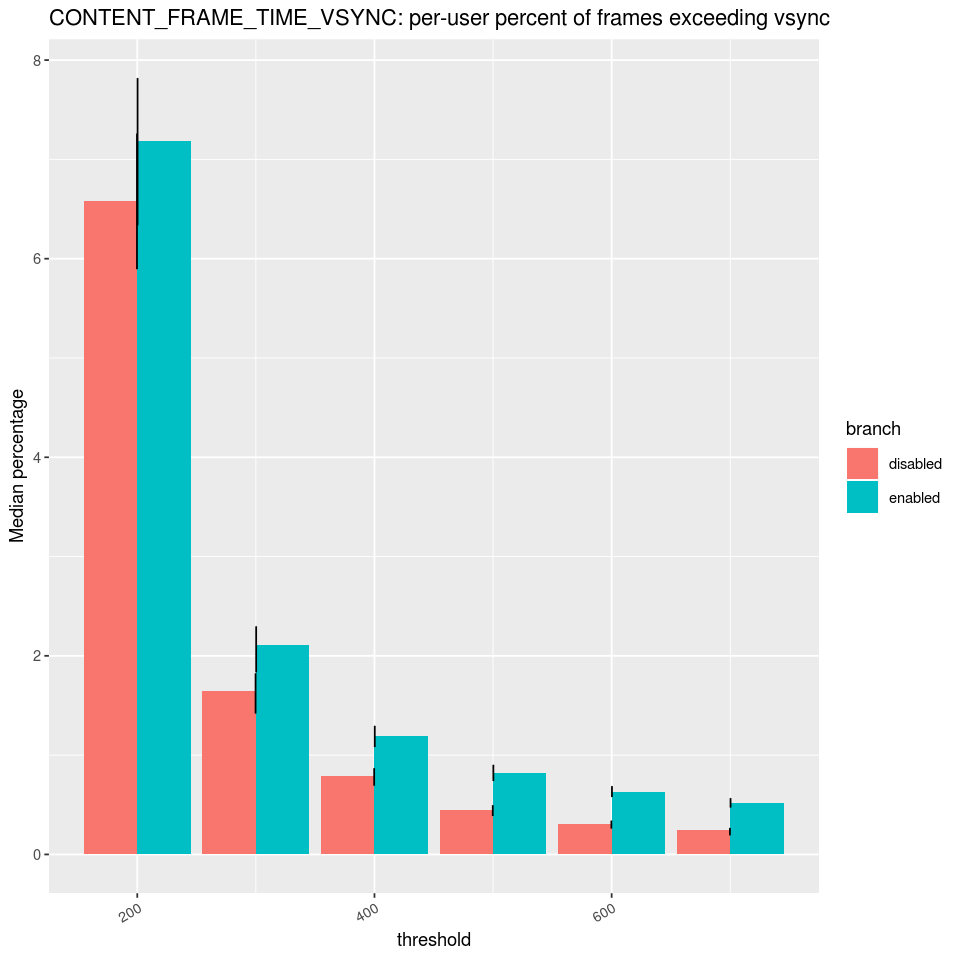

In [30]:
%r
slow_content_frame_time_vsync_total_summary %>%
  #inner_join(display_builds) %>%
  ggplot(aes(threshold, y, ymin=ymin, ymax=ymax, fill=branch)) +
    #facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title=sprintf("CONTENT_FRAME_TIME_VSYNC: per-user percent of frames exceeding vsync"), y="Median percentage")

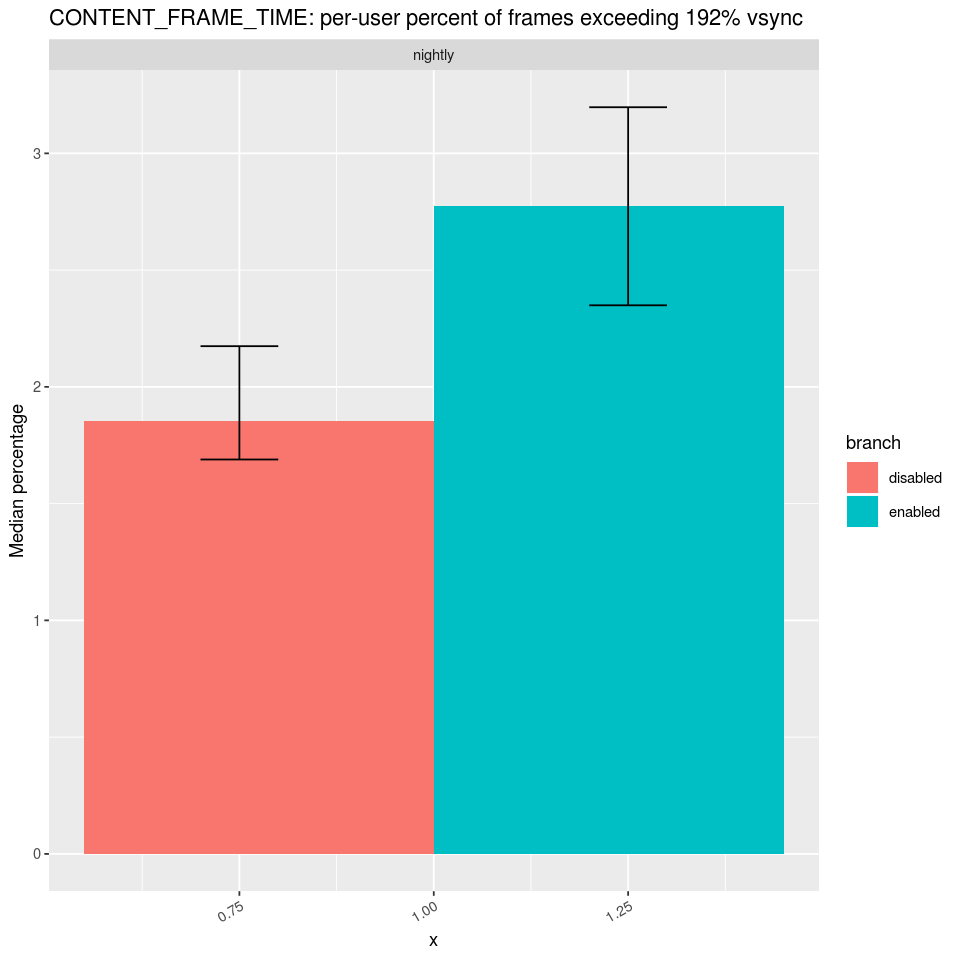

In [31]:
%r
slow_content_frame_time_total_summary %>%
  #inner_join(display_builds) %>%
  ggplot(aes(1, y, ymin=ymin, ymax=ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title="CONTENT_FRAME_TIME: per-user percent of frames exceeding 192% vsync", y="Median percentage")

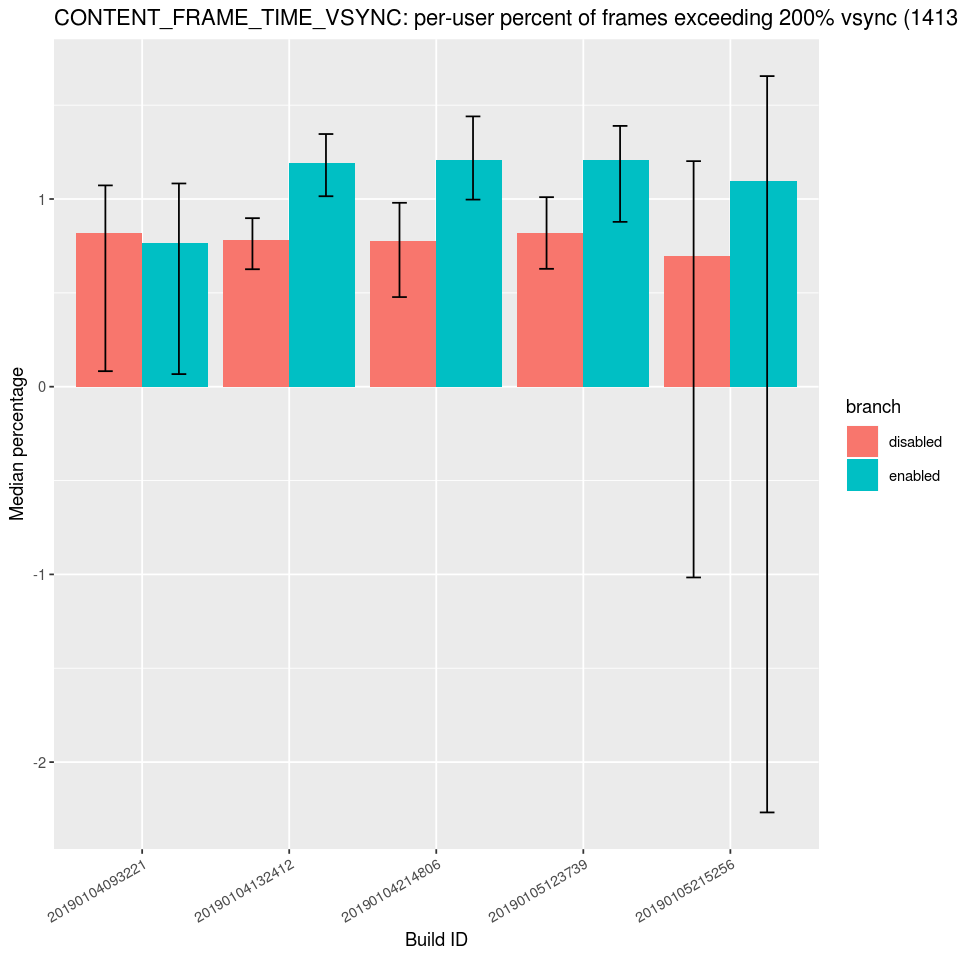

In [32]:
%r
slow_content_frame_time_vsync_summary %>%
  #inner_join(display_builds) %>%
  ggplot(aes(app_build_id, y, ymin=ymin, ymax=ymax, fill=branch)) +
    #facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title=sprintf("CONTENT_FRAME_TIME_VSYNC: per-user percent of frames exceeding 200%% vsync (%d users)", nrow(slow_content_frame_time_vsync)), x="Build ID", y="Median percentage")

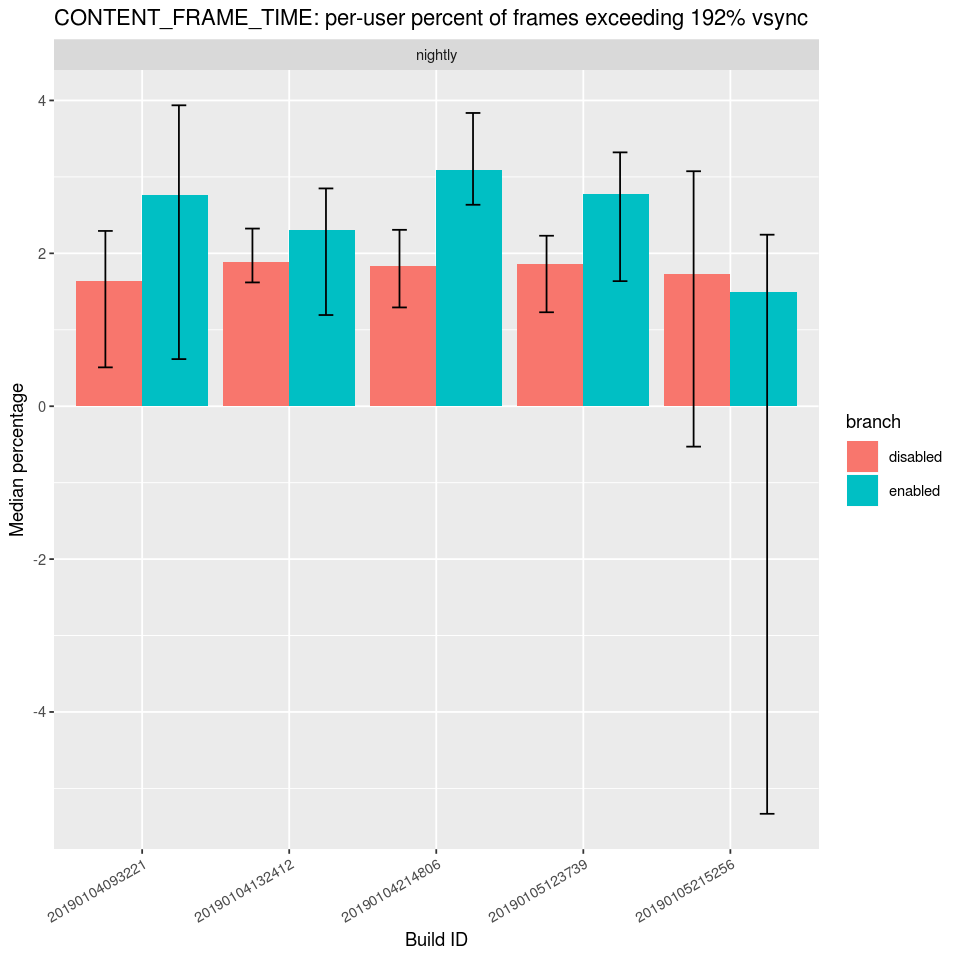

In [33]:
%r
slow_content_frame_time_summary %>%
  #inner_join(display_builds) %>%
  ggplot(aes(app_build_id, y, ymin=ymin, ymax=ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title="CONTENT_FRAME_TIME: per-user percent of frames exceeding 192% vsync", x="Build ID", y="Median percentage")

In [34]:
%r
slow_content_frame_time %>% filter(app_build_id == '20190104093221')

# A tibble: 54 x 6
 client_id branch app_build_id normalized_chan… threshold fraction_exceed…
 
 1 c3b92be2-82… enabl… 20190104093… nightly 192 0.114 
 2 4fcb4af6-bd… enabl… 20190104093… nightly 192 0.0119 
 3 a7254d6a-5a… enabl… 20190104093… nightly 192 0.00285
 4 c494aa61-ca… disab… 20190104093… nightly 192 0.0286 
 5 5c702947-3a… enabl… 20190104093… nightly 192 0.0320 
 6 d58810b6-76… enabl… 20190104093… nightly 192 0.00500
 7 f11c3205-8b… enabl… 20190104093… nightly 192 0.0126 
 8 9dadf9b7-72… enabl… 20190104093… nightly 192 0.0321 
 9 f39d2a14-f6… disab… 20190104093… nightly 192 0.00379
10 c139edc3-c6… enabl… 20190104093… nightly 192 0.0594 
# ... with 44 more rows

In [35]:
%r
joined <- slow_content_frame_time %>% filter(app_build_id == '20190104093221') %>% inner_join(slow_content_frame_time_vsync, by=c('app_build_id', 'branch', 'client_id', 'normalized_channel'), suffix=c('192', 'vsync')) %>% select(branch, fraction_exceeding192, fraction_exceedingvsync)
joined %>% arrange(branch,fraction_exceeding192)

# A tibble: 54 x 3
 branch fraction_exceeding192 fraction_exceedingvsync
 
 1 disabled 0.00122 0.00134
 2 disabled 0.00258 0.00128
 3 disabled 0.00379 0.0132 
 4 disabled 0.00481 0.00607
 5 disabled 0.00554 0.00769
 6 disabled 0.00683 0.0147 
 7 disabled 0.00970 0.0146 
 8 disabled 0.0106 0.0108 
 9 disabled 0.0146 0.0155 
10 disabled 0.0147 0.0193 
# ... with 44 more rows

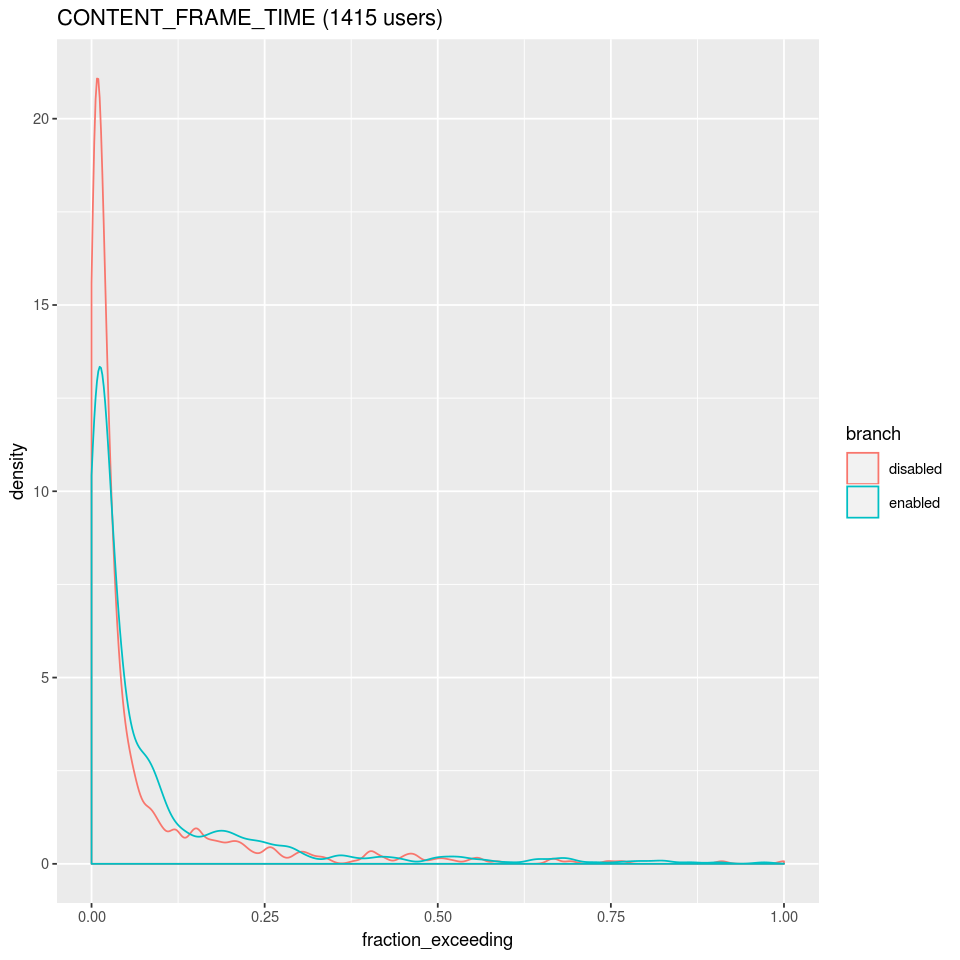

In [36]:
%r
slow_content_frame_time %>% ggplot(aes(x=fraction_exceeding, color=branch)) + geom_density() + labs(title=sprintf("CONTENT_FRAME_TIME (%d users)", nrow(slow_content_frame_time)))

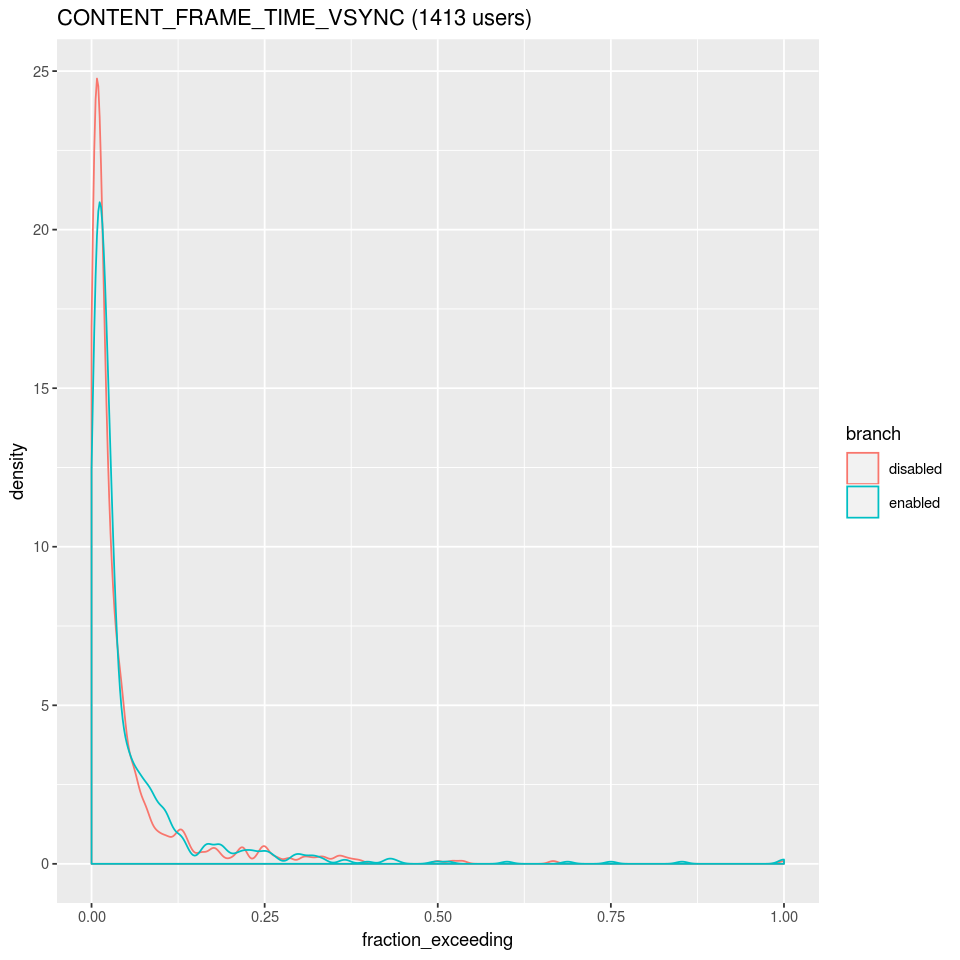

In [37]:
%r
slow_content_frame_time_vsync %>% ggplot(aes(x=fraction_exceeding, color=branch)) + geom_density() + labs(title=sprintf("CONTENT_FRAME_TIME_VSYNC (%d users)", nrow(slow_content_frame_time_vsync)))

In [38]:
%r
weighted_content_frame_time_vsync = tbl(sc, "global_temp.wr_weighted_content_frame_time_vsync") %>% collect
weighted_content_frame_time_vsync

# A tibble: 1,413 x 6
 client_id branch app_build_id normalized_chan… threshold fraction_exceed…
 
 1 1bcbf4c4-d5… enabl… 20190104214… nightly 200 0.00566
 2 4e2282e9-eb… disab… 20190104132… nightly 200 1.20 
 3 5329ffa6-1a… enabl… 20190104214… nightly 200 0.0801 
 4 698995da-88… disab… 20190104132… nightly 200 1.01 
 5 8cfe1411-7b… disab… 20190104214… nightly 200 0.0879 
 6 c2a9be81-f7… enabl… 20190104132… nightly 200 0.0990 
 7 c3b92be2-82… enabl… 20190104093… nightly 200 0.222 
 8 fdebffce-9a… enabl… 20190105123… nightly 200 0.0249 
 9 051071ba-3c… disab… 20190104132… nightly 200 0.135 
10 7b8ad60b-9b… enabl… 20190104214… nightly 200 0.386 
# ... with 1,403 more rows

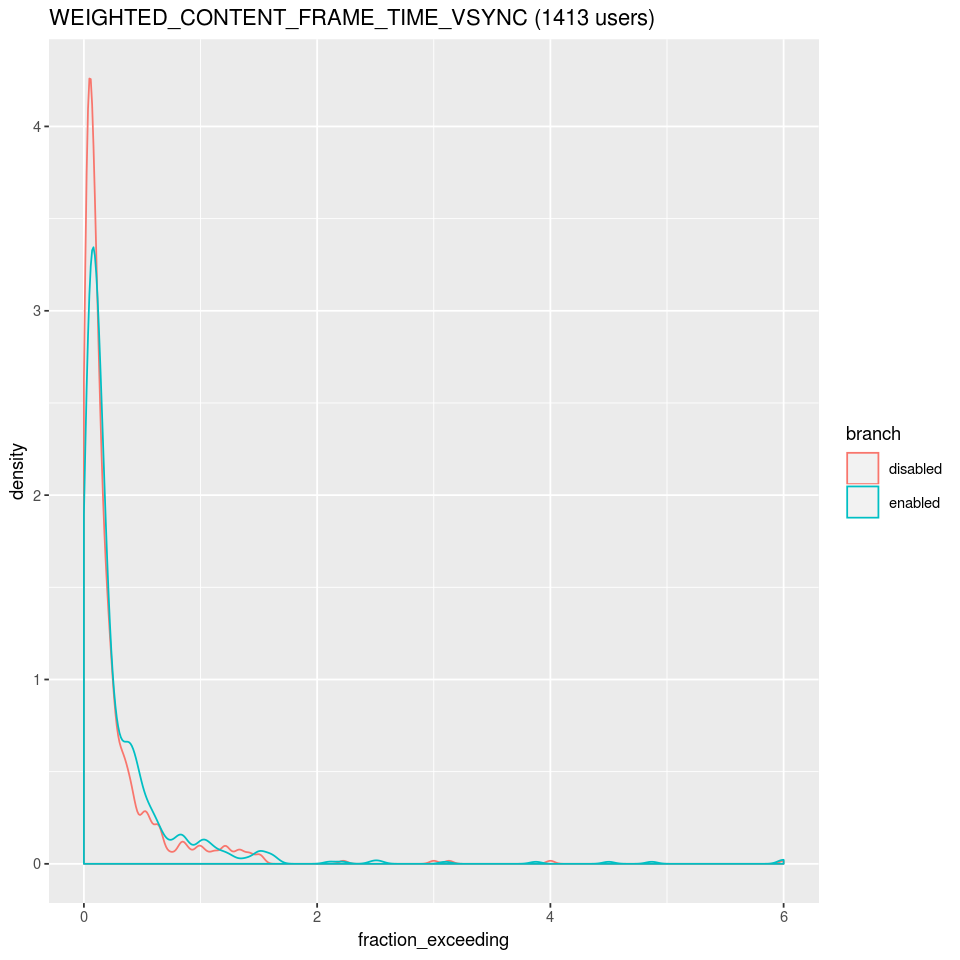

In [39]:
%r
weighted_content_frame_time_vsync %>% ggplot(aes(x=fraction_exceeding, color=branch)) + geom_density() + labs(title=sprintf("WEIGHTED_CONTENT_FRAME_TIME_VSYNC (%d users)", nrow(slow_content_frame_time_vsync)))

In [40]:
%r
weighted_content_frame_time_vsync_total_summary = weighted_content_frame_time_vsync %>%
  group_by(normalized_channel, branch) %>%
  do(slow_content_frame_boot(.))
weighted_content_frame_time_vsync_total_summary

# A tibble: 2 x 5
# Groups: normalized_channel, branch [2]
 normalized_channel branch ymin y ymax
 
1 nightly disabled 8.90 10.4 11.2
2 nightly enabled 12.3 13.4 14.4

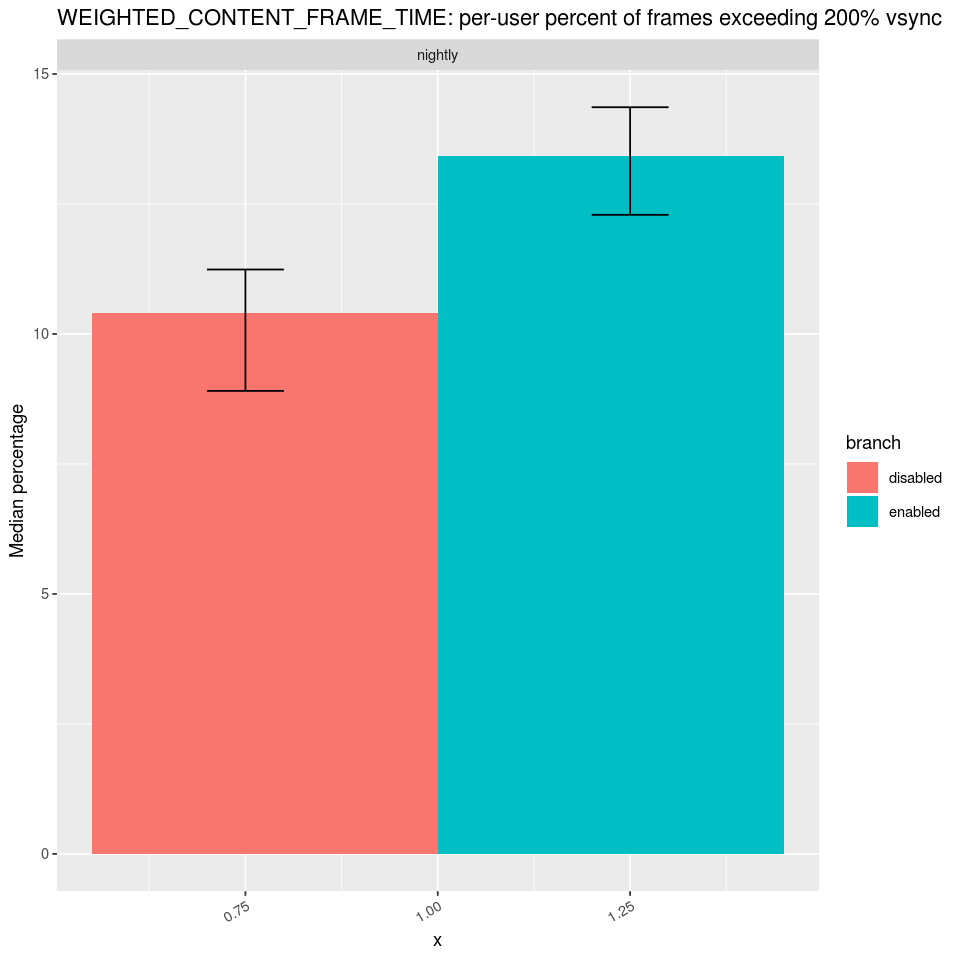

In [41]:
%r
weighted_content_frame_time_vsync_total_summary %>%
  #inner_join(display_builds) %>%
  ggplot(aes(1, y, ymin=ymin, ymax=ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title="WEIGHTED_CONTENT_FRAME_TIME: per-user percent of frames exceeding 200% vsync", y="Median percentage")

In [42]:
%r
slow_content_frame_time %>% filter(app_build_id == '20190104093221') %>% filter(branch == 'enabled') %>% summary

client_id branch app_build_id normalized_channel
 Length:31 Length:31 Length:31 Length:31 
 Class :character Class :character Class :character Class :character 
 Mode :character Mode :character Mode :character Mode :character 
 
 
 
 threshold fraction_exceeding
 Min. :192 Min. :0.001333 
 1st Qu.:192 1st Qu.:0.012235 
 Median :192 Median :0.020127 
 Mean :192 Mean :0.052835 
 3rd Qu.:192 3rd Qu.:0.057244 
 Max. :192 Max. :0.373545

In [43]:
%r
slow_content_frame_time %>% filter(app_build_id == '20190104093221') %>% filter(branch == 'disabled') %>% summary

client_id branch app_build_id normalized_channel
 Length:22 Length:22 Length:22 Length:22 
 Class :character Class :character Class :character Class :character 
 Mode :character Mode :character Mode :character Mode :character 
 
 
 
 threshold fraction_exceeding
 Min. :192 Min. :0.001217 
 1st Qu.:192 1st Qu.:0.007215 
 Median :192 Median :0.017009 
 Mean :192 Mean :0.047030 
 3rd Qu.:192 3rd Qu.:0.032803 
 Max. :192 Max. :0.314286

In [44]:
%r
  summarize_slow = function(df) {
    mystat = function(data, indices) {
      sample = data[indices,]
      median(sample[sample$branch == "enabled",]$fraction_exceeding, na.rm=TRUE) / median(sample[sample$branch == "disabled",]$fraction_exceeding, na.rm=TRUE)
    }

    ci = df %>%
      boot(mystat, 200, strata=factor(df$branch)) %>%
      boot.ci(0.95, type="basic")
    data.frame(
      ymin=ci$basic[4],
      y=ci$t0,
      ymax=ci$basic[5]
    ) * 100
  }
bind_rows(summarize_slow(slow_content_frame_time) %>% mutate(metric="slow_content_frame_time"),
          summarize_slow(slow_content_frame_time_vsync) %>% mutate(metric="slow_content_frame_time_vsync")) %>%
  select(metric, ymin, y, ymax)


metric ymin y ymax
1 slow_content_frame_time 104.62625 146.2150 176.8782
2 slow_content_frame_time_vsync 84.10455 106.3167 119.9159

In [45]:
%r
slow_content_frame_boot_p90 = function(df) {
  ci = boot(df$fraction_exceeding, function(data, x) quantile(data[x], 0.9, na.rm=TRUE), 1000) %>%
     boot.ci(0.95, "basic")
  data.frame(
    ymin=ci$basic[4],
    y=ci$t0,
    ymax=ci$basic[5]
  ) * 100
}

slow_content_frame_time_summary_p90 = slow_content_frame_time %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  do(slow_content_frame_boot_p90(.))